In [65]:
import cv2
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt


In [ ]:
img_color = cv2.imread('cat.jpg')

im = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

In [38]:
def threshold_image(im, th):
    m = np.zeros_like(im, dtype=np.uint8)
    m[im >= th] = 1
    return m

In [39]:
def compute_otsu_criteria(im, th):
    bin_im = threshold_image(im, th)
    nb_pixel  = im.size
    nb_pixel1    = np.count_nonzero(bin_im)
    w1     = nb_pixel1 / nb_pixel 
    w0     = 1 - w1
    if w0 == 0 or w1 == 0:
        return np.inf

    vals1 = im[bin_im == 1]
    vals0 = im[bin_im == 0]
    var0  = np.var(vals0) if vals0.size>0 else 0
    var1  = np.var(vals1) if vals1.size>0 else 0

    return w0 * var0 + w1 * var1

In [40]:
def fitness_from_criteria(im, th, eps=1e-6):
    return 1.0/(compute_otsu_criteria(im, th) + eps)

In [41]:
def run_ga_otsu(im, pop_size, n_gen, cross_rate, mut_rate):
    start = time.time()
    pop = [random.randint(0,255) for _ in range(pop_size)]
    for _ in range(n_gen):
        fits = [fitness_from_criteria(im, t) for t in pop]
        total = sum(fits)
        probs = [f/total for f in fits] if total>0 else [1/pop_size]*pop_size

        new_pop = []
        while len(new_pop) < pop_size:
            dad, mom = random.choices(pop, probs, k=2)
            # crossover
            if random.random() < cross_rate:
                bd, bm = format(dad,'08b'), format(mom,'08b')
                pt = random.randint(1,7)
                c1 = int(bd[:pt]+bm[pt:],2)
                c2 = int(bm[:pt]+bd[pt:],2)
            else:
                c1, c2 = dad, mom
            
            def mutate(x):
                if random.random() < mut_rate:
                    b = list(format(x,'08b'))
                    i = random.randrange(8)
                    b[i] = '1' if b[i]=='0' else '0'
                    return int(''.join(b),2)
                return x
            new_pop.append(mutate(c1))
            if len(new_pop)<pop_size:
                new_pop.append(mutate(c2))
        pop = new_pop

    # pemilihan yang terbaik
    fits = [fitness_from_criteria(im, t) for t in pop]
    idx  = int(np.argmax(fits))
    return pop[idx], fits[idx], time.time()-start


In [49]:
POP_SIZE       = 30
CROSS_RATE     = 0.8
MUT_RATES      = [0.01, 0.05, 0.1, 0.2]
FIXED_GENERASI = 40
N_REPEATS      = 5

results = []
for m in MUT_RATES:
    for run in range(N_REPEATS):
        th, fit, rt = run_ga_otsu(im,
                                  pop_size=POP_SIZE,
                                  n_gen=FIXED_GENERASI,
                                  cross_rate=CROSS_RATE,
                                  mut_rate=m)
        results.append(['MUT_RATE', m, run+1, th, fit, rt])


In [50]:
GENS       = [10,20,40,60]
FIXED_MUT  = 0.1

for g in GENS:
    for run in range(N_REPEATS):
        th, fit, rt = run_ga_otsu(im,
                                  pop_size=POP_SIZE,
                                  n_gen=g,
                                  cross_rate=CROSS_RATE,
                                  mut_rate=FIXED_MUT)
        results.append(['N_GENERATIONS', g, run+1, th, fit, rt])


In [67]:
df = pd.DataFrame(results,
                  columns=['param','value','run','best_th','best_fit','runtime_s'])

summary = (df
    .groupby(['param','value'])
    .agg(th_mean=('best_th','mean'),
         fit_mean=('best_fit','mean'),
         rt_mean=('runtime_s','mean'),
         th_std =('best_th','std'),
         fit_std =('best_fit','std'),
         rt_std  =('runtime_s','std'))
    .reset_index()
)

print(summary)

           param  value  th_mean  fit_mean    rt_mean    th_std       fit_std  \
0       MUT_RATE   0.01    124.2  0.001210  26.980262  3.271085  7.121003e-06   
1       MUT_RATE   0.05    127.8  0.001211  25.293022  3.701351  5.320861e-06   
2       MUT_RATE   0.10    127.8  0.001211  24.856120  3.768289  5.327605e-06   
3       MUT_RATE   0.20    127.8  0.001214  23.161121  1.483240  9.173291e-07   
4  N_GENERATIONS  10.00    127.4  0.001213   6.314480  2.701851  1.728114e-06   
5  N_GENERATIONS  20.00    126.6  0.001214  12.352161  1.516575  5.126751e-07   
6  N_GENERATIONS  40.00    126.6  0.001214  24.457233  1.140175  4.402555e-07   
7  N_GENERATIONS  60.00    126.2  0.001213  34.885760  2.049390  1.214851e-06   

     rt_std  
0  1.281488  
1  1.481121  
2  0.979940  
3  0.100727  
4  0.255027  
5  0.596427  
6  0.775766  
7  1.093601  


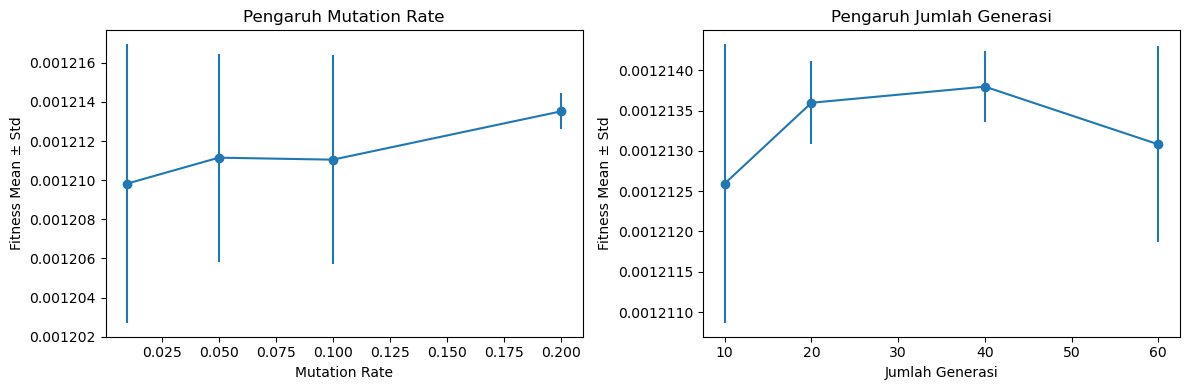

In [68]:
fig, axes = plt.subplots(1,2, figsize=(12,4))

# Plot fitness vs MUT_RATE
ax = axes[0]
sub = summary[summary.param=='MUT_RATE']
ax.errorbar(sub.value, sub.fit_mean, yerr=sub.fit_std, fmt='-o')
ax.set_xlabel('Mutation Rate')
ax.set_ylabel('Fitness Mean ± Std')
ax.set_title('Pengaruh Mutation Rate')

# Plot fitness vs N_GENERATIONS
ax = axes[1]
sub = summary[summary.param=='N_GENERATIONS']
ax.errorbar(sub.value, sub.fit_mean, yerr=sub.fit_std, fmt='-o')
ax.set_xlabel('Jumlah Generasi')
ax.set_ylabel('Fitness Mean ± Std')
ax.set_title('Pengaruh Jumlah Generasi')

plt.tight_layout()
plt.show()


In [69]:
POP_SIZE    = 30
CROSS_RATE  = 0.8
MUT_RATE    = 0.2   
N_GENERASI  = 20     

best_th, best_fit, best_rt = run_ga_otsu(
    im,
    pop_size=POP_SIZE,
    n_gen=N_GENERASI,
    cross_rate=CROSS_RATE,
    mut_rate=MUT_RATE
)

mask = threshold_image(im, best_th)      
mask255 = (mask * 255).astype(np.uint8) 

print("Threshold =", best_th)



Threshold = 126


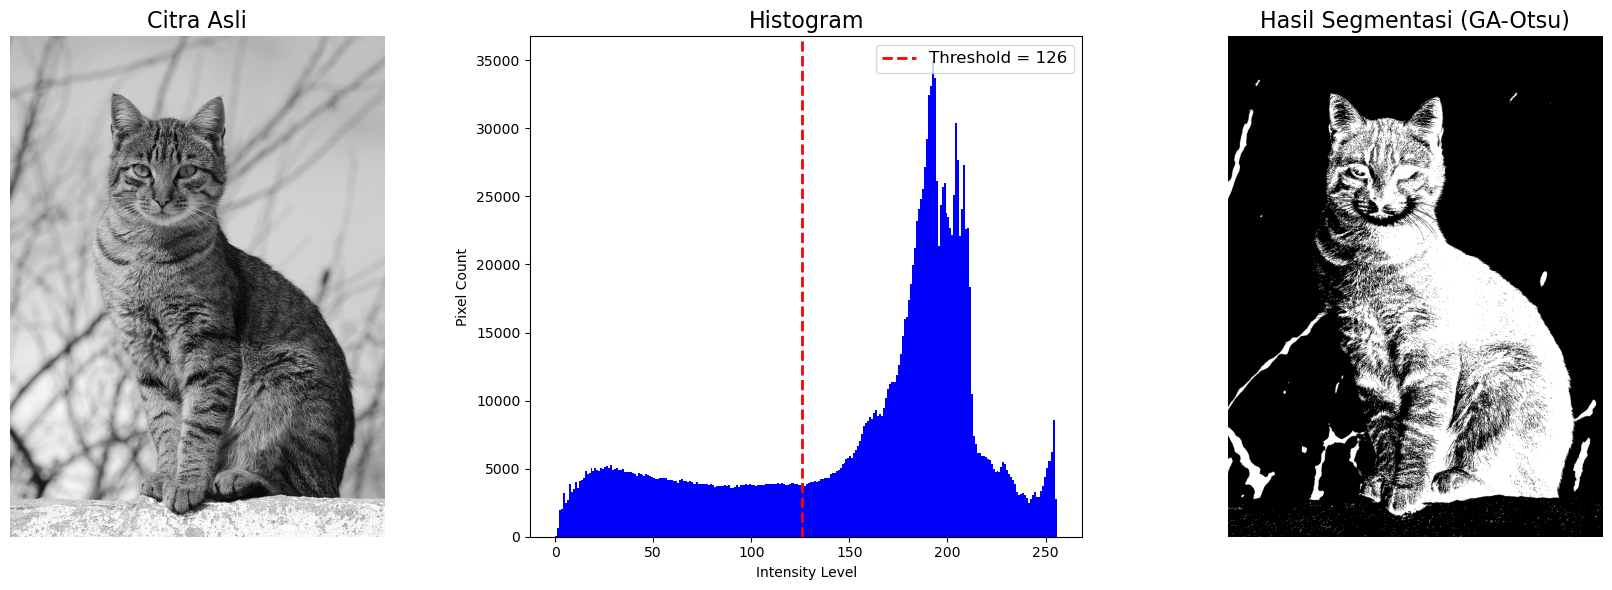

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

ax = axes[0]
ax.imshow(im, cmap='gray')
ax.set_title('Citra Asli', fontsize=16)
ax.axis('off')

ax = axes[1]

ax.hist(im.ravel(), bins=256, range=(0,256), color='blue')

ax.axvline(best_th, color='red', linestyle='--', linewidth=2)

ax.legend([f'Threshold = {best_th}'], loc='upper right', fontsize=12)
ax.set_title('Histogram', fontsize=16)
ax.set_xlabel('Intensity Level')
ax.set_ylabel('Pixel Count')

ax = axes[2]
ax.imshow(mask255, cmap='gray_r')
ax.set_title('Hasil Segmentasi (GA-Otsu)', fontsize=16)
ax.axis('off')

plt.tight_layout()
plt.show()